# 0. Abstract

Este proyecto se enfoca en el estudio de emociones en texto mediante modelos de análisis de sentimientos, poniendo especial atención en valorar el desempeño de varios modelos de aprendizaje automático en un amplio conjunto de datos de manifestaciones emocionales. La base de datos, que alberga más de 1.5 millones de registros, abarca información textual clasificada por varias categorías emocionales. El propósito del análisis es anticipar evaluaciones de las emociones, categorizando las emociones en dos grupos: positivas (1) y negativas (0). El procedimiento abarca etapas de preprocesamiento de datos tales como tokenización, supresión de términos de interrupción y stemming. El estudio de las emociones se lleva a cabo mediante modelos de aprendizaje automático, tales como Regresión Logística y Random Forest, y su desempeño se mide mediante indicadores como la accuracy y F1-Score.

## Hipótesis:
La hipótesis de esta investigación es que los modelos de aprendizaje automático tienen la capacidad de categorizar eficazmente las expresiones emocionales en un texto, siendo los algoritmos de Regresión Logística y Random Forest los que brinden alta exactitud en la proyección de notas de sentimientos. Adicionalmente, se supone que la supresión de emociones neutras en el conjunto de datos potenciará la habilidad del modelo para diferenciar entre emociones positivas y negativas.

## Objetivos

### Procesar la Colección de Datos:

- El cargar y limpiar el conjunto de datos implica gestionar clases desequilibradas, eliminar emociones neutrales y normalizar las etiquetas de sentimiento.
- Implementar métodos de preprocesamiento de texto, como la tokenización, la supresión de verbos innecesarios y la stemming, para acondicionar el texto para su modelación.

### Análisis de Características:

- Emplear métodos como CountVectorizer y TfidfVectorizer para transformar el texto en atributos numéricos que sean incorporables en los modelos de aprendizaje automático.

### Formación de Modelos:

- Desarrollar modelos de estudio de emociones, en particular Regresión Logística y Random Forest, basándose en datos de texto previamente procesados.
- Analizar la eficacia de los modelos empleando precisión y calificación F1.

### Análisis del Modelo:

- Evaluar la eficacia de los distintos modelos e identificar el modelo más eficaz para la categorización de las emociones.
- Examinar la relevancia de los atributos empleados por los modelos, como los términos más comunes que aportan a la categorización.

### Descripción de los Resultados:

- Examinar los hallazgos para reconocer los puntos fuertes y débiles de los modelos y ofrecer visiones acerca de las manifestaciones emocionales más predictivas en el conjunto de datos.


# 1. Importamos librerías

In [ ]:
import nltk # importar natural language toolkit
nltk.download('punkt')
nltk.download('stopwords') # modulo para descargar stopwords en diferentes idiomas
nltk.download('wordnet')
from nltk.corpus import stopwords
import pandas as pd
import numpy  as np
import re
import string
import plotly
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import zipfile
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 2. Cargamos dataset

In [ ]:
# URL del archivo zip
url = "https://github.com/PGrimaldiP/emotion_text_analysis/raw/85f1941712d23ccc87f7e071d928a7c6c7af4acf/emotion_sentimen_dataset.csv.zip"

# Descargamos el archivo zip
!wget -O emotion_sentimen_dataset.zip {url}

# Creamos una carpeta para extraer el contenido
extraction_folder = 'emotion_sentimen_dataset'
os.makedirs(extraction_folder, exist_ok=True)

# Extraemos el contenido del archivo ZIP
with zipfile.ZipFile('emotion_sentimen_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

# Verificamos los archivos extraídos
extracted_files = os.listdir(extraction_folder)
print("Archivos extraídos:", extracted_files)

# Buscamos el archivo CSV
csv_file_path = None
for file in extracted_files:
    if file.endswith('.csv'):
        csv_file_path = os.path.join(extraction_folder, file)
        break

# Cargamos el dataset en un DataFrame
df = pd.read_csv(csv_file_path)

# Mostramos las primeras filas del DataFrame para verificar la carga
print(df.head())


--2025-01-27 21:53:31--  https://github.com/PGrimaldiP/emotion_text_analysis/raw/85f1941712d23ccc87f7e071d928a7c6c7af4acf/emotion_sentimen_dataset.csv.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PGrimaldiP/emotion_text_analysis/85f1941712d23ccc87f7e071d928a7c6c7af4acf/emotion_sentimen_dataset.csv.zip [following]
--2025-01-27 21:53:31--  https://raw.githubusercontent.com/PGrimaldiP/emotion_text_analysis/85f1941712d23ccc87f7e071d928a7c6c7af4acf/emotion_sentimen_dataset.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19577336 (19M) [application/zip]
Saving to: ‘emotion_sentimen_data

# 3. EDA

Comenzamos con un análisis preeliminar del dataset

In [ ]:
df.shape

(500047, 3)

El primer problema o dificultad es que nos enfrentamos a un dataset con más de 1.5 millones de registros. Esto indica que muy probablemente debamos realizar una reducción de dimensionalidad debido a limitantes técnicas. Adicionalmente, es un dataset con pocas columnas, siendo la primera una columna de índice, la segunda texto y la tercera una emoción asociada al texto.

Text(0, 0.5, 'Frecuencia')

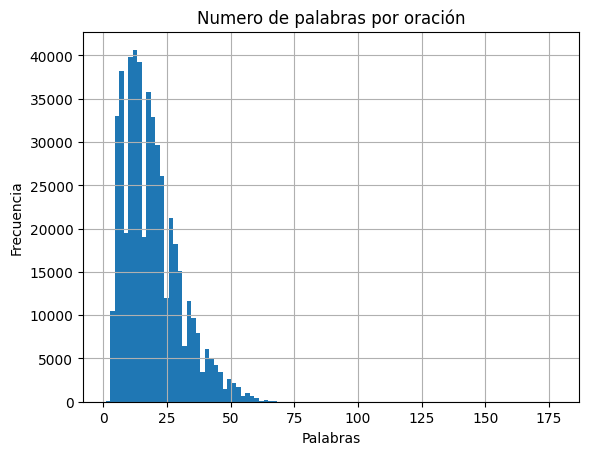

In [ ]:
words_per_sentence = df.text.apply(lambda x: len(x.split(" ")))
words_per_sentence.hist(bins = 100)
plt.title('Numero de palabras por oración')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

De la revisión vemos una distribución sesgada a la derecha, lo que indica que la gran parte de los textos es de una baja cantidad de palabra viendo una concentración mayor en el rango de 0 a 25.

In [ ]:
words_per_sentence.mean()

19.214547832503744

In [ ]:
df.Emotion.value_counts()

,count
Emotion,
neutral,401913
love,23390
happiness,16248
sadness,10382
relief,9906
hate,9121
anger,7391
fun,5950
enthusiasm,5518


Notamos inmediatamente que existe un desbalanceo en los textos neutrales vs los de otras emociones.

Text(0, 0.5, 'Porcentaje (%)')

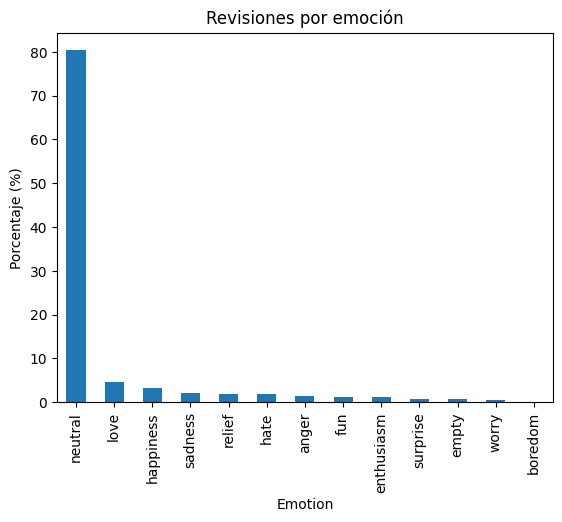

In [ ]:
percent_val = 100 * df.Emotion.value_counts()/df.shape[0]

percent_val.plot.bar()
plt.title('Revisiones por emoción')
plt.xlabel('Emotion')
plt.ylabel('Porcentaje (%)')

Predominando en torno a un 80% este tipo de textos. De todas formas, dado que queremos realizar sentiment analysis, podríamos obviar los casos neutrales y atribuir emociones "positivas" como 1 y "negativas" como 0 para estandarizar el dataset.

In [ ]:
# removiendo neutrales
df = df[df.Emotion != 'neutral']

# Asignando Sentiment_rating según las emociones
positive_emotions = ['love', 'happiness', 'relief', 'fun', 'enthusiasm', 'surprise']
df['Sentiment_rating'] = np.where(df.Emotion.isin(positive_emotions), 1,0)

# Contando la cantidad de cada Sentiment_rating
print(df['Sentiment_rating'].value_counts())

Sentiment_rating
1    65172
0    32962
Name: count, dtype: int64


<ipython-input-9-f6af23e31d9e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment_rating'] = np.where(df.Emotion.isin(positive_emotions), 1,0)


Queda un tanto desbalanceado el dataset en torno a 66 y 33% para cada categoría. Convertiremos el texto a minúscula para ver si se modifica un poco la cantidad de tokens obtendis

In [ ]:
df['text_new'] = df.text.apply(lambda x: x.lower())

<ipython-input-10-14f55b050628>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_new'] = df.text.apply(lambda x: x.lower())


In [ ]:
nltk.download('punkt_tab')

token_lists = [word_tokenize(each) for each in df.text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos antes: ", len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in df.text_new]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Numero de tokens unicos antes:  35094
Numero de tokens unicos nuevos:  35094


Vemos que no hay diferencia entre los tokens obtenidos, esto se debe a que el texto se encontraba en minúscula. Veremos si al eliminar caracteres especiales disminuye en algo el dataset para ver si podría resultar interesante eliminar estos mismos.

In [ ]:
# Seleccionando los caracteres no alfa numericos que no son espacios
special_chars = df.text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# obtener una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

set()


Vemos que se generó un set vacío de caracteres, lo que nos indica que el texto no se encontraba con caracteres especiales. Por lo que no hace sentido eliminar estos mismo y mantendremos la cantidad original de tokens. Cargaremos las stopwords, es importante señalar que se debe utilizar el idioma inglés dado que el texto es en inglés.

In [ ]:
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words

179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Luego miramos las palabras más frecuentes es decir el top 1% de palabras en los textos.

In [ ]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:10]

[('i', 177080),
 ('and', 79343),
 ('feel', 68127),
 ('to', 64419),
 ('the', 61381),
 ('a', 40200),
 ('that', 37060),
 ('of', 36852),
 ('feeling', 34115),
 ('my', 31986)]

Text(0, 0.5, 'Frecuencia')

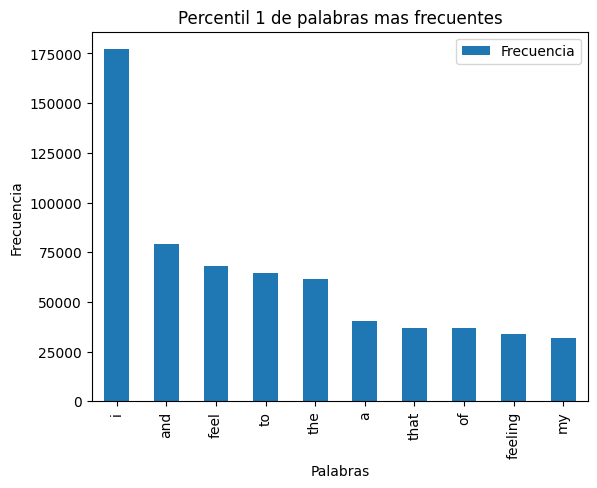

In [ ]:
pd.DataFrame(top_1_percentile[:10], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

Vemos que las palabras más relevantes se asocacian a textos de expresión de emociones, palabras como "yo", "siento", "sentimiento", "mío" podría indicar que las sentencias tienden a ser personales.

In [ ]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('plowshares', 1),
 ('bandy', 1),
 ('sonic', 1),
 ('abstruse', 1),
 ('relished', 1),
 ('backtoherroots', 1),
 ('benne', 1),
 ('rickyricardo', 1),
 ('magdalena', 1),
 ('mcconnell', 1)]

No vemos nada muy relevante al buscar el top 1% inferior de palabras, sólo palabras extrañas o de poco uso, que se pueden atribuir a situaciones específicas. Añadiremos ambos tops a la colección de noise_words

In [ ]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

# 3. Modelado

Comenzaremos con la vectorización para la creación de la bolsa de palabras (bow)

In [ ]:
# Creacion de metodo para stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [ ]:
# Creacion de un objeto tipo CountVectorizer
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 1)
)

Ahora que generamos la bolsa de palabras podemos proceder a crear los dataset de entrenamiento y testeo

In [ ]:
emotions_train, emotions_test = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
X_train_bow = bow_counts.fit_transform(emotions_train.text_new)
X_test_bow = bow_counts.transform(emotions_test.text_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", "n't", 'sha', 'wo'] not in stop_words.
  warnings.warn(


Crearemos los dataset de salida asociados a las variables de sentiment_rating que es la que nos interesa predecir.

In [ ]:
y_train_bow = emotions_train['Sentiment_rating']
y_test_bow = emotions_test['Sentiment_rating']

In [ ]:
y_test_bow.value_counts() / y_test_bow.shape[0]

,count
Sentiment_rating,
1,0.668365
0,0.331635


Analizamos que la distribución resulta ser bastante similar a cuando revisamos el shape del sentiment_rating.

##3.1 Regresión logística

In [ ]:
# Entrenar el modelo
lr_model_all = LogisticRegression(C=1, solver="liblinear")
lr_model_all.fit(X_train_bow, y_train_bow)

# Predecir el output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.8367325446694983
Accuracy:  76.30305191827584


En el primer modelo de regresión logística obtenemos valores buenos para un modelo en general, pero no son los mejores, revisaremos si existen opciones para mejorar las métricas del modelo u otros modelos con mejor rendimiento.

In [ ]:
test_pred_lr_prob

array([[0.20799095, 0.79200905],
       [0.13655542, 0.86344458],
       [0.35399146, 0.64600854],
       ...,
       [0.34813987, 0.65186013],
       [0.97028311, 0.02971689],
       [0.17725903, 0.82274097]])

In [ ]:
probabilities = [each[1] for each in test_pred_lr_prob]

In [ ]:
predictions = pd.DataFrame()
predictions['text'] = emotions_test['text']
predictions['Actual_Emotions'] = emotions_test['Emotion']
predictions['Sentiment_rating'] = emotions_test['Sentiment_rating']
predictions['Predicted_sentiment'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities

In [ ]:
predictions.head(5)

,text,Actual_Emotions,Sentiment_rating,Predicted_sentiment,Predicted_probability
192014,i certainly don t feel joyful the way all thos...,fun,1,1,0.792009
290085,i feel elegant when i do and its so comfortabl...,relief,1,1,0.863445
196095,i really hope i find something i love that mak...,love,1,1,0.646009
100935,i have stewed and thought about the sad emptin...,sadness,0,1,0.643453
320823,i decided to join this forum because i am a lo...,love,1,1,0.996418


Vemos que la probabilidad de predicción es bastante irregular entre los disintos valore,s teniendo extremos como 0.9964 como otros valores tipo 0.6434 de todas maneras son buenos valores para un modelo real.

In [ ]:
accuracy_score(predictions['Sentiment_rating'], predictions['Predicted_sentiment'])

0.7630305191827584

El accuracy como vimos anteriormente no es el mejor y creo que se podría mejorar.

In [ ]:
predictions[
    predictions['Predicted_sentiment'] != predictions['Sentiment_rating']
].sort_values(by=["Predicted_probability"]).head(3)

,text,Actual_Emotions,Sentiment_rating,Predicted_sentiment,Predicted_probability
233792,i was feeling unhappy i felt dispirited lethar...,happiness,1,0,0.010070
158377,i was swtiching through all of the news channe...,surprise,1,0,0.016948
411074,i have spent the last month or so slowly withd...,happiness,1,0,0.025238


Ahora bien si aplicamos esto sobre casos en que la predicción del sentiment es <> del valor real, vemos que da probabilidades de predicción bastante bajas, en torno al 1-2%. Probaremos cambiando el ngram_range para ajustar y mejorar el modelo.

## 3.2 Regresión ajustada

In [ ]:
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_bow = bow_counts.fit_transform(emotions_train.text_new)
X_test_bow = bow_counts.transform(emotions_test.text_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train_bow

<78507x2206942 sparse matrix of type '<class 'numpy.int64'>'
	with 6310712 stored elements in Compressed Sparse Row format>

In [ ]:
lr_model_all_new = LogisticRegression(C=0.9, solver="liblinear")

In [ ]:
# Entrenar el modelo
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predecir resultados
test_pred_lr_prob = lr_model_all_new.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.9914555880454183
Accuracy:  98.85362001324705


Ahora vemos que el mismo modelo es altamente predictivo y es posible que incluso esté sobreajustado al tener un nivel de F-1 Score esto da para considerar un modelo overfit.

In [ ]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names_out(),
        lr_model_all_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:15]

,words,weights
1164367,love,5.000830
1176968,loved,4.391223
1737160,surprised,3.974819
717632,funny,3.958401
556520,excited,3.943133
778219,happy,3.867230
293285,beloved,3.857413
1180242,lovely,3.797080
714380,fun,3.757562
1631476,shocked,3.724444


In [ ]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

,words,weights
405212,concerned,-4.294538
239688,avoid,-4.402700
789233,hate,-4.696065
794947,hateful,-4.812297
474520,discouraged,-5.000261
185096,angry,-5.151917
192094,anxiety,-5.187809
792788,hated,-5.382998
2104378,whatever,-5.426239
2170023,worry,-5.453362


## 3.3 Random forest

In [39]:
rf_model_all = RandomForestClassifier(n_estimators=50)

# Entrenamiento
rf_model_all.fit(X_train_bow, y_train_bow)

# predicciones
test_pred_lr_prob = rf_model_all.predict_proba(X_test_bow)
test_pred_lr_all = rf_model_all.predict(X_test_bow)

In [40]:
print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9705193501617161
Accuracy:  95.9596474244663


Vemos que los resultados entregados por random forest son un poco más reales que la segunda regresión y por lo tanto con menor probabilidad de overfitting. Además, son mejores resultados que los generados en la primera regresión, por lo que para este ejercicio consideramos que es el modelo más apto.

In [41]:
feature_importances = pd.DataFrame(
    rf_model_all.feature_importances_,
    index=bow_counts.get_feature_names_out(),
    columns=['importance']
)

In [42]:
feature_importances.sort_values(['importance'], ascending=False)[:10]

,importance
sad,0.022814
hated,0.014965
i hate,0.013421
depressed,0.012403
angry,0.011380
love,0.011111
empty,0.010968
hate,0.010716
melancholy,0.008978
whatever,0.007225


Revisamos las features más importantes

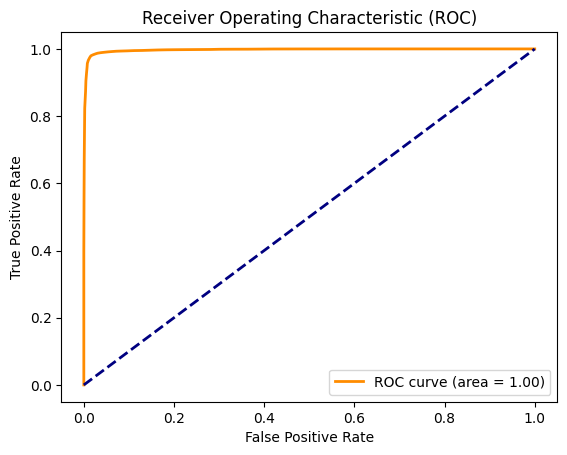

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculando la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_bow, test_pred_lr_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Graficando la curva
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Finalmente observamos la curva ROC AUC generada

# 4. Conclusiones

En este proyecto se realizó un texto de análisis de emociones; los experimentos se basaron en la tarea de clasificar el sentimiento del texto de las expresiones emocionales presentes en un corpus grande. Después de realizar el pre-procesamiento y la transformación de texto: tokenizado, stopword-removing, stemming. Se entrenaron diferentes tipos de modelo de aprendizaje para distinguir solo entre los estados de emociones positivas y negativas

Luego de comparar diferentes modelos, tales como Regresión Logística y Random Forest, el modelo de Random Forest es considerado más eficiente para la tarea de análisis de sentimiento. Tanto en accuracy como en F1-Score tiene resultados bastante bueno y no llegando al extremo de un modelo overfitting como el caso de la regresión logísctica ajustada.

La importancia de las features también demostró que Random Forest consiguió reconocer y emplear eficazmente términos fundamentales en los textos que representan las emociones, lo cual favoreció su excelente desempeño. Pese a que el conjunto de datos planteaba algunos retos, como el desequilibrio de clases y la exigencia de suprimir las emociones neutrales, el modelo de Random Forest logró gestionar estos elementos de forma correcta, logrando una categorización bastante precisa de las emociones.

En conclusión, Random Forest ha probado ser el modelo más sólido y fiable para este tipo de análisis de emociones en texto, lo que indica que podría ser una magnífica alternativa para trabajos parecidos en el futuro, particularmente cuando se manejan grandes cantidades de información y se requiere una clasificación exacta y eficaz.